# Creating the corpus.csv

In [5]:
import pandas as pd
import os

folder_path = "data/newari_data_archive"

filenames = []
texts = []
for file in os.listdir(folder_path):
    filenames.append(file)
    with open(os.path.join(folder_path, file), "r", encoding="utf-8") as f:
        content = f.read()
        content = content.replace("\n", " ")
        texts.append(content)

corpus = pd.DataFrame({
    "filename": filenames,
    "text": texts
})

corpus.to_csv("data/corpus.csv", index=False)

This one is faster.

In [11]:
from pathlib import Path
import pandas as pd

folder_path = Path("data/newari_data_archive")

files = list(folder_path.glob("*"))

corpus = pd.DataFrame({
    "filename": [f.name for f in files],
    # "text": [f.read_text(encoding="utf-8").replace("\n", " ") for f in files]
    "text": [f.read_text(encoding="utf-8") for f in files]
})

corpus.to_csv("data/corpus.csv", index=False)

# Building a rule based tokenizer

In [24]:
import pandas as pd
import re

In [30]:
corpus = pd.read_csv("data/corpus_trec.csv")

In [26]:
_DEVANAGARI_PATTERN = re.compile(r'[\u0900-\u0963\u0966-\u097F]+')

with open("data/stopwords.txt", "r", encoding="utf-8") as f:
    _STOPWORDS = set(line.strip() for line in f)

def tokenize(text):
    # extract words but ignore । and ॥
    words = _DEVANAGARI_PATTERN.findall(text)
    normalized = [word.replace("\u0940", "\u093F").replace("\u0942", "\u0941") for word in words]
    return [word for word in normalized if word not in _STOPWORDS]

# Computing Term Frequency

In [21]:
from collections import Counter

def compute_term_frequency(documents):
    term_frequency = Counter()
    for document in documents:
        term_frequency.update(tokenize(document))

    # return term_frequency.most_common()
    return sorted(term_frequency.items(), key=lambda x: x[0])

# term_frequencies = compute_term_frequency(corpus['text'].tolist())

# df = pd.DataFrame(term_frequencies, columns=['term', 'frequency'])
# df.to_csv("data/term_frequency_alphabetically.csv", index=False)

In [10]:
# df = pd.read_csv("data/term_frequency.csv")
# df.shape

(246461, 2)

In [18]:
# df = df[df['frequency'] > 3000]
# df.shape

(438, 2)

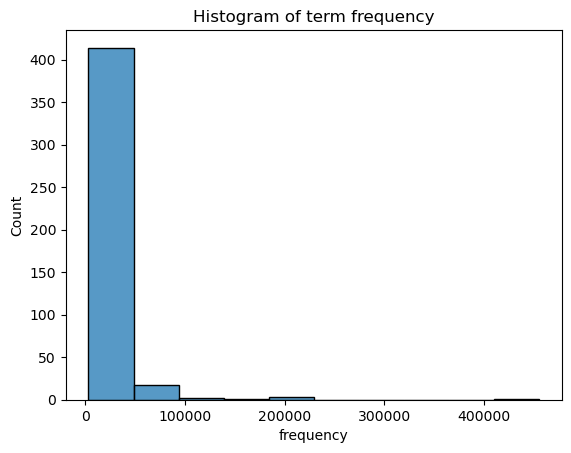

In [19]:
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# sns.histplot(df, x="frequency", bins=10, kde=False)
# plt.title("Histogram of term frequency")
# plt.show()

In [20]:
# df.to_csv("data/stopwords.csv", index=False)

# Term weighing for the documents using tf.idf

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    use_idf=True,
    sublinear_tf=True,
)

tfidf_matrix = vectorizer.fit_transform(corpus["text"].tolist())
tfidf_matrix.shape

/home/sujal/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(80380, 246435)

In [28]:
print(type(tfidf_matrix))

<class 'scipy.sparse._csr.csr_matrix'>


# Building the inverted index using the tfidf matrix

In [38]:
def build_inverted_index(tfidf_matrix, vectorizer):
    from collections import defaultdict
    coo = tfidf_matrix.tocoo()
    inverted_index = defaultdict(list)
    terms = vectorizer.get_feature_names_out()

    for docid, termid, weight in zip(coo.row, coo.col, coo.data):
        inverted_index[terms[termid]].append((docid, weight))

    for postings in inverted_index.values():
        postings.sort(key=lambda x: x[1], reverse=True)

    return inverted_index

inverted_index = build_inverted_index(tfidf_matrix, vectorizer)

<class 'numpy.ndarray'>
246435


# Implementing the search functionality

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query, tfidf_matrix, vectorizer, top_k=10):
    query_vector = vectorizer.transform([query])
    similarities = cosine_similarity(query_vector, tfidf_matrix)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [(idx, similarities[idx]) for idx in top_indices]

# Saving the vectorizer and tfidf matrix

In [50]:
import pickle
import scipy.sparse

# Save the vectorizer
with open('models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the TF-IDF matrix
scipy.sparse.save_npz('models/tfidf_matrix.npz', tfidf_matrix)

# Testing the search function

In [33]:
output = search("नेपाल भारतया", tfidf_matrix, vectorizer, top_k=3)

ids = corpus['DocID']
for docid, score in output:
    print("Document id: " + str(ids[docid]) + " with score " + str(score) + "\n")
    print(corpus['text'].iloc[docid])
    print("\n----------------\n")

Document id: NWA74681 with score 0.22677464279830878



लिधंसा

स्वयादिसँ 
 http://dpe.nic.in/survey01/vol1/APENDIX3.pdf

भारतया अर्थतन्त्र

----------------

Document id: NWA74118 with score 0.21997317352807302

नेपाल सम्बतया छन्हु ख। थ्व दिं खुनु जूगु घटना थ्व कथं दु-

घटना
 नेपाल लिपि गुथिया पलिस्था

तजिलजि

स्वयादिसँ
 नेपाल सम्बत

दसमि

----------------

Document id: NWA15370 with score 0.20337000283178944

महिन्द्र मल्लयात नेपाल भाषाया आदिकवि कथं नालातःगु दु ।

नेपाल भाषा साहित्य

----------------



# Run utilities

In [42]:
# trec_utils.py

def save_trec_run(qid, doc_id_list, score_list, system_name, filename, mode='a'):
    """
    Saves a list of retrieved documents into the standard TREC run format.

    Format: QID ITERATION_ID DOCID RANK SCORE SYSTEM_NAME
    """
    with open(filename, mode) as f:
        # ITERATION_ID is typically QID-A (or just 'Q0') but we'll use QID-SystemName for uniqueness
        iteration_id = f"{qid}-{system_name}"
        
        # Ensure lists are the same length
        num_results = len(doc_id_list)
        
        for rank, (docid, score) in enumerate(zip(doc_id_list, score_list)):
            # TREC ranks start at 1
            trec_rank = rank + 1
            
            # Format: QID Q0 DOCID RANK SCORE SYSTEM_NAME
            # Note: The standard format often uses 'Q0' for the second column, 
            # but using the system name here helps with internal tracking.
            line = f"{qid} {system_name} {docid} {trec_rank} {score:.6f}\n"
            f.write(line)

def read_topics_xml(filename):
    """
    A simple function to parse QID and Title from your topics.xml file.
    (Requires the 'xml.etree.ElementTree' module, which is standard)
    """
    import xml.etree.ElementTree as ET
    
    queries = []
    tree = ET.parse(filename)
    root = tree.getroot()
    
    for topic in root.findall('top'):
        qid = topic.find('num').text.strip().replace('Q', '').replace('q', '').strip() # Clean QID
        title = topic.find('title').text.strip()
        
        # Pad QID to four digits (e.g., '1' -> '0001') for consistency
        queries.append({
            'qid': f"Q{qid.zfill(4)}",
            'title': title
        })
    return queries

# Creating a tfidf_run.txt file

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

def tokenize(text):
    # extract words but ignore । and ॥
    words = _DEVANAGARI_PATTERN.findall(text)
    normalized = [word.replace("\u0940", "\u093F").replace("\u0942", "\u0941") for word in words]
    return [word for word in normalized if word not in _STOPWORDS]

def compute_tfidf(corpus):
    vectorizer = TfidfVectorizer( tokenizer=tokenize, token_pattern=None, use_idf=True, sublinear_tf=True)

    tfidf_matrix = vectorizer.fit_transform(corpus["text"].tolist())

    return tfidf_matrix, vectorizer

def search(query, tfidf_matrix, vectorizer, top_k=10):
    query_vector = vectorizer.transform([query])
    similarities = cosine_similarity(query_vector, tfidf_matrix)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [(idx, similarities[idx]) for idx in top_indices]

In [46]:
# tfidf_runner.py
import pandas as pd

# --- Configuration ---
TOP_K = 50
TOPICS_FILE = "data/newa_queries.trec"
RUN_FILE = "data/tfidf_run.txt"
CORPUS_FILE = 'data/corpus_trec.csv'
SYSTEM_NAME = 'TFIDF'

def run_tfidf_retrieval():
    print(f"--- Running {SYSTEM_NAME} Model ---")
    
    # 1. Load Data and Compute TF-IDF
    corpus = pd.read_csv(CORPUS_FILE)
    # The DocID column must be correctly named in your corpus.csv
    doc_ids = corpus['DocID'].tolist() 
    
    tfidf_matrix, vectorizer = compute_tfidf(corpus)
    
    # 2. Load Queries
    queries = read_topics_xml(TOPICS_FILE)
    
    # 3. Clear previous run file and run queries
    with open(RUN_FILE, 'w') as f: # Clear the file by opening in write mode ('w')
        pass

    for query in queries:
        qid = query['qid']
        title = query['title']
        
        # VSM Search (Using your existing utility structure)
        # Assuming newautils.vsm.search returns a list of tuples (DocID, Score)
        try:
            results = search(title, tfidf_matrix, vectorizer, top_k=TOP_K)
            
            # Extract DocIDs and Scores from the search result tuples
            doc_id_list = [doc_ids[r[0]] for r in results]
            score_list = [r[1] for r in results]
            
            # Save to TREC format (append mode)
            save_trec_run(qid, doc_id_list, score_list, SYSTEM_NAME, RUN_FILE, mode='a')
            print(f"Processed Query {qid} with {len(results)} results.")
            
        except Exception as e:
            print(f"Error processing {qid} ('{title}'): {e}")
    
    print(f"TF-IDF retrieval complete. Results saved to {RUN_FILE}")

run_tfidf_retrieval()

--- Running TFIDF Model ---
Processed Query Q0001 with 50 results.
Processed Query Q0002 with 50 results.
Processed Query Q0003 with 50 results.
Processed Query Q0004 with 50 results.
Processed Query Q0005 with 50 results.
Processed Query Q0006 with 50 results.
Processed Query Q0007 with 50 results.
Processed Query Q0008 with 50 results.
Processed Query Q0009 with 50 results.
Processed Query Q0010 with 50 results.
Processed Query Q0011 with 50 results.
Processed Query Q0012 with 50 results.
Processed Query Q0013 with 50 results.
Processed Query Q0014 with 50 results.
Processed Query Q0015 with 50 results.
Processed Query Q0016 with 50 results.
Processed Query Q0017 with 50 results.
Processed Query Q0018 with 50 results.
Processed Query Q0019 with 50 results.
Processed Query Q0020 with 50 results.
Processed Query Q0021 with 50 results.
Processed Query Q0022 with 50 results.
Processed Query Q0023 with 50 results.
Processed Query Q0024 with 50 results.
Processed Query Q0025 with 50 result

# Creating a muril_run.txt file

In [ ]:
# muril_runner.py
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# --- Configuration ---
TOP_K = 50
TOPICS_FILE = "data/newa_queries.trec"
RUN_FILE = "data/muril_run.txt"
CORPUS_FILE = 'data/corpus_trec.csv'
SYSTEM_NAME = 'MURIL'
MODEL_NAME = "sundeepdwd/muril-mlm-newa-finetuned"

def get_mean_pooling(model_output, attention_mask):
    """Mean pooling to get a single vector representation for the sequence."""
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def run_muril_retrieval():
    print(f"--- Running {SYSTEM_NAME} Model ---")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # 1. Load Model and Data
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    
    model.to(device)

    corpus = pd.read_csv(CORPUS_FILE)
    doc_ids = corpus['DocID'].tolist() 
    doc_texts = corpus['text'].tolist()

    # NOTE: This step is memory intensive. For 80,000+ docs, pre-calculate embeddings once.
    print("Computing document embeddings (can take time for large corpus)...")
    doc_embeddings = []
    
    # Batch processing is recommended for 80k+ documents, but for simplicity:
    for text in doc_texts:
        tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        tokens.to(device)
        with torch.no_grad():
            output = model(**tokens)
        doc_embeddings.append(get_mean_pooling(output, tokens['attention_mask']))
        
    all_doc_embeddings = torch.cat(doc_embeddings)
    
    # 2. Load Queries
    queries = read_topics_xml(TOPICS_FILE)
    
    # 3. Clear previous run file and run queries
    with open(RUN_FILE, 'w') as f:
        pass

    for query in queries:
        qid = query['qid']
        title = query['title'] # Use the title as the query text

        # 4. Compute Query Embedding
        query_tokens = tokenizer(title, return_tensors='pt', truncation=True, padding=True)
        query_tokens.to(device)
        with torch.no_grad():
            query_output = model(**query_tokens)
        query_embedding = get_mean_pooling(query_output, query_tokens['attention_mask'])
        
        # 5. Calculate Cosine Similarity
        # Compare the query embedding to all document embeddings
        # The result is a 1D tensor of scores
        scores = F.cosine_similarity(query_embedding, all_doc_embeddings)
        
        # 6. Sort and Select Top K
        top_scores, top_indices = torch.topk(scores, k=min(TOP_K, len(scores)))
        
        # Retrieve the corresponding DocIDs
        top_doc_ids = [doc_ids[i.item()] for i in top_indices]
        
        # Save to TREC format
        save_trec_run(qid, top_doc_ids, top_scores.tolist(), SYSTEM_NAME, RUN_FILE, mode='a')
        print(f"Processed Query {qid} with {len(top_doc_ids)} results.")
        
    print(f"MuRIL retrieval complete. Results saved to {RUN_FILE}")

if __name__ == "__main__":
    run_muril_retrieval()

--- Running MURIL Model ---


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at sundeepdwd/muril-mlm-newa-finetuned and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Computing document embeddings (can take time for large corpus)...


# Adding docid to corpus.csv

In [14]:
import pandas as pd

df = pd.read_csv("data/corpus.csv")
output_filename = "data/corpus_trec.csv"
prefix =  "NWA"
num_docs = len(df)
    
# Determine how many digits are needed for zero-padding (e.g., 80123 -> 5 digits)
padding_length = len(str(num_docs))

print(f"Found {num_docs} documents. Using {padding_length} digits for DocID padding.")

# 3. Generate the sequential, padded DocIDs
# Create a list of numbers (1, 2, 3, ...)
doc_numbers = range(1, num_docs + 1)

# Format the numbers with zero-padding and add the prefix
# Example: 1 -> '00001', 80123 -> '80123'
docids = [f'{prefix}{num:0{padding_length}d}' for num in doc_numbers]

# 4. Insert the new DocID column
# We insert it as the first column for clarity
df.insert(0, 'DocID', docids)

# 5. Save the new, clean corpus file
df.to_csv(output_filename, index=False)



Found 80380 documents. Using 5 digits for DocID padding.


# Ramdomly sampling documents for the query document evaluation data

In [1]:
import pandas as pd
# Read the corpus CSV
corpus = pd.read_csv('data/corpus_trec.csv')

# Randomly sample 100 documents
sample_size = 1000
queryset = corpus[['DocID', 'text']].sample(n=sample_size, random_state=45)

# Save to queryset.csv
queryset.to_csv('data/queryset.csv', index=False)

# Creating the queries.csv

In [9]:
import pandas as pd

df = pd.read_csv("data/querydoc.csv")
df.head()
output_filename = "data/queries.csv"
prefix = "Q"
num_docs = len(df)
    
# Determine how many digits are needed for zero-padding (e.g., 80123 -> 5 digits)
padding_length = len(str(num_docs))

print(f"Found {num_docs} documents. Using {padding_length} digits for DocID padding.")

# 3. Generate the sequential, padded DocIDs
# Create a list of numbers (1, 2, 3, ...)
doc_numbers = range(1, num_docs + 1)

# Format the numbers with zero-padding and add the prefix
# Example: 1 -> '00001', 80123 -> '80123'
docids = [f'{prefix}{num:0{padding_length}d}' for num in doc_numbers]

# 4. Insert the new DocID column
# We insert it as the first column for clarity
df.insert(0, 'QueryID', docids)

# 5. Save the new, clean corpus file
df[['QueryID', 'Query']].to_csv(output_filename, index=False)


Found 1000 documents. Using 4 digits for DocID padding.


# creating the ground truth 

In [12]:
import pandas as pd

queries = pd.read_csv("data/queries.csv")
querydoc = pd.read_csv("data/querydoc.csv")

df = pd.DataFrame()
df['QueryID'] = queries['QueryID']
df['relevant docs'] = querydoc['DocID']

df.to_csv('data/groundtruth.csv', index=False)